**IMPORT LIBRARY CNN**

In [1]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sn

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.models import load_model

**INITIAL STATE**

In [2]:
EPOCHS = 30
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
directory_root = "../input/corn-or-maize-leaf-disease-dataset"
width=64
height=64
depth=3
n_folds= 5

**LOADING DATASET**

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Common_Rust ...
[INFO] Processing Blight ...
[INFO] Processing Healthy ...
[INFO] Processing Gray_Leaf_Spot ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['Blight' 'Common_Rust' 'Gray_Leaf_Spot' 'Healthy']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

**SPLITTING DATASET**

In [9]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


**CREATING MODEL Alexnet**

In [10]:
def create_model():
    
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

## Layer 1
    model.add(Conv2D(96, strides = (4, 4), kernel_size = (11, 11), activation = "relu", 
                    kernel_initializer = "he_uniform", padding = "valid", input_shape = inputShape)) 
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
    model.add(BatchNormalization())

## Layer 2
    model.add(Conv2D(256, padding = "same", kernel_size = (5, 5), activation = "relu", 
                    kernel_initializer = "he_uniform"))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
    model.add(BatchNormalization())

## Layer 3
    model.add(Conv2D(384, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_uniform", 
                    padding = "same"))
    model.add(BatchNormalization())

## Layer 4 
    model.add(Conv2D(384, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_uniform", 
                    padding = "same"))
    model.add(BatchNormalization())

## Layer 5 
    model.add(Conv2D(256, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_uniform", 
                    padding = "same"))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (3, 3)))


## Flatten the Model and Connect it 
# To Connected Layer 
    model.add(Flatten())
    model.add(Dense(4096, activation = "relu", kernel_initializer = "he_uniform"))
    model.add(Dropout(0.3))

## Dense 2 
    model.add(Dense(1500, kernel_initializer = "he_uniform", activation = "relu"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

## Dense 3 
    model.add(Dense(1000, kernel_initializer = "he_uniform", activation = "relu"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

## Output Layer
    model.add(Dense(4, activation = "softmax", kernel_initializer = "glorot_uniform"))

    return model

2022-12-26 17:42:56.761047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 17:42:56.868453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 17:42:56.869493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 17:42:56.871366: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

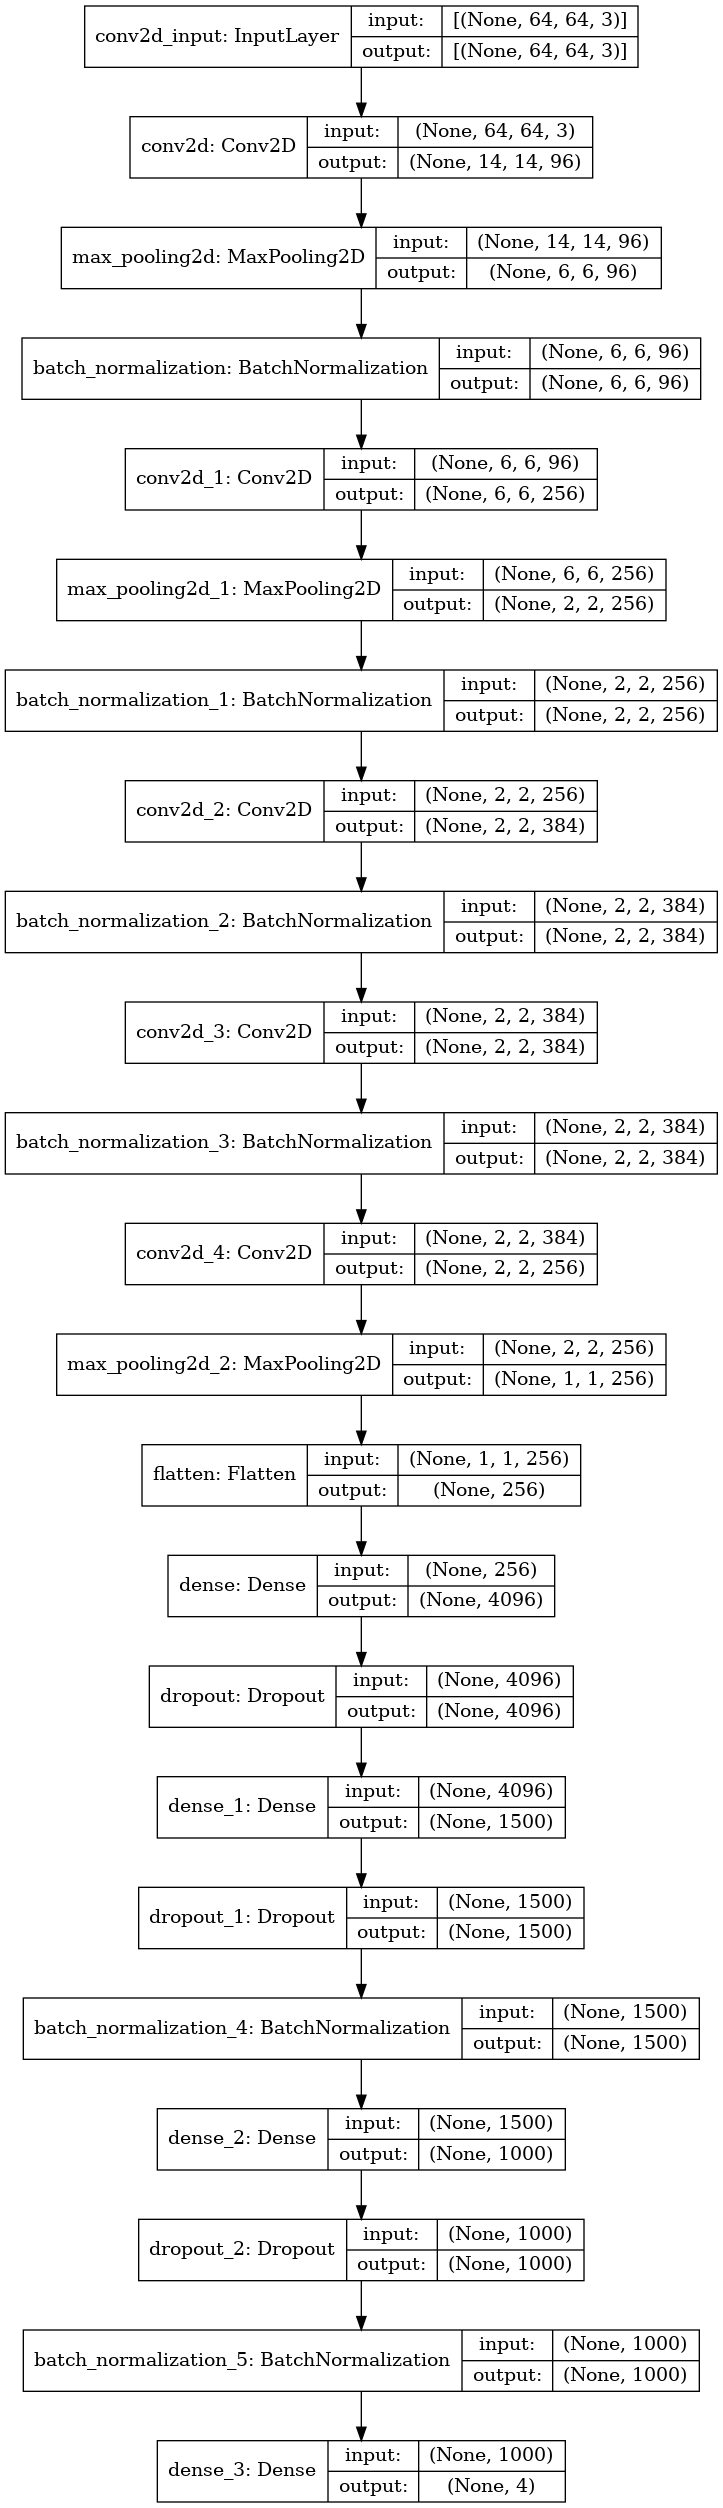

In [11]:
model = create_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 96)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 96)          384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 256)         614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 384)         8

**INITIATE OPTIMIZER**

In [13]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


**CHECKPOINT CREATING MODEL FOR CROSS VALIDATION**

In [14]:
filepath="model.alexnet"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size):
    model = create_model()
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    results = model.fit(t_x, t_y,validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    
    return results

**TRAINING DATA WITH CROSS VALIDATION**

In [15]:
#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs=EPOCHS, batch_size=BS))
print("======="*12, end="\n\n\n")

Training on Fold:  1


2022-12-26 17:43:01.057457: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-26 17:43:03.778435: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


84/84 [==============================] - 10s 19ms/step - loss: 0.8202 - accuracy: 0.7204 - val_loss: 8.1884 - val_accuracy: 0.2970

Epoch 00001: val_loss improved from inf to 8.18841, saving model to model.alexnet


2022-12-26 17:43:12.207555: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/30
84/84 [==============================] - 1s 11ms/step - loss: 0.5194 - accuracy: 0.7988 - val_loss: 1.2128 - val_accuracy: 0.4164

Epoch 00002: val_loss improved from 8.18841 to 1.21279, saving model to model.alexnet
Epoch 3/30
84/84 [==============================] - 1s 11ms/step - loss: 0.3983 - accuracy: 0.8346 - val_loss: 1.3081 - val_accuracy: 0.4328

Epoch 00003: val_loss did not improve from 1.21279
Epoch 4/30
84/84 [==============================] - 1s 11ms/step - loss: 0.3980 - accuracy: 0.8421 - val_loss: 1.0149 - val_accuracy: 0.6433

Epoch 00004: val_loss improved from 1.21279 to 1.01488, saving model to model.alexnet
Epoch 5/30
84/84 [==============================] - 1s 10ms/step - loss: 0.3220 - accuracy: 0.8820 - val_loss: 0.9912 - val_accuracy: 0.6955

Epoch 00005: val_loss improved from 1.01488 to 0.99123, saving model to model.alexnet
Epoch 6/30
84/84 [==============================] - 1s 12ms/step - loss: 0.2802 - accuracy: 0.8951 - val_loss: 2.6389 - val

**RESULT OF TRAINING DATA PROCESS**

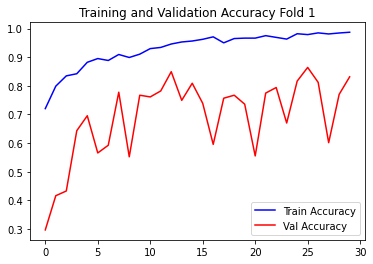

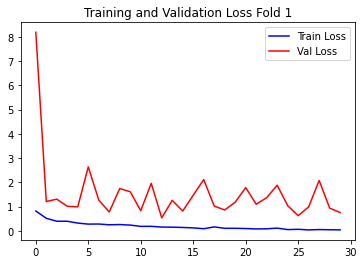

In [16]:
#FOLD 1
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 1')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 1.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Loss Fold 1')
plt.plot(model_history[0].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[0].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 1.jpg")
plt.show()

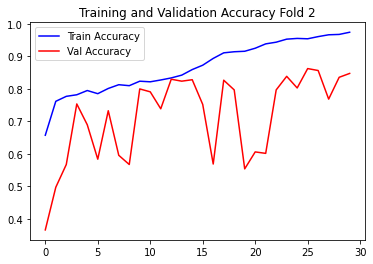

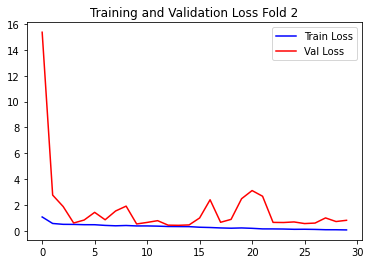

In [17]:
#FOLD 2
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 2')
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 2.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Loss Fold 2')
plt.plot(model_history[1].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 2.jpg")
plt.show()

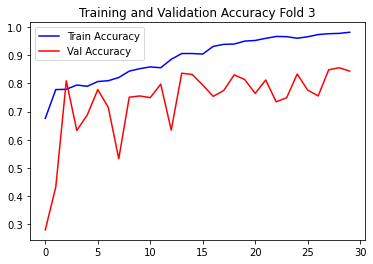

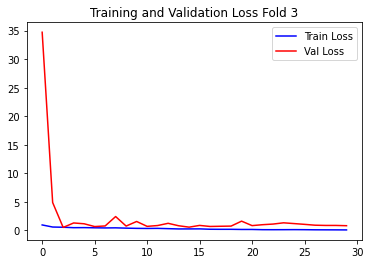

In [18]:
#FOLD 3
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 3')
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 3.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Loss Fold 3')
plt.plot(model_history[2].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 3.jpg")
plt.show()

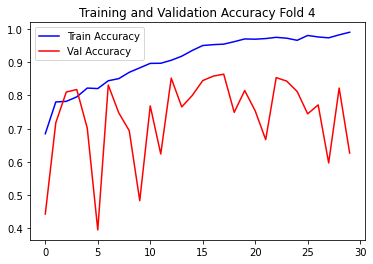

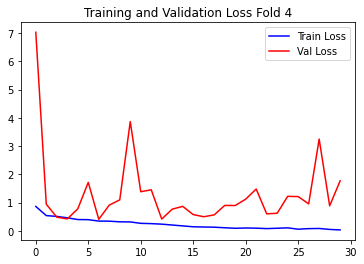

In [19]:
#FOLD 4
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 4')
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 4.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Loss Fold 4')
plt.plot(model_history[3].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 4.jpg")
plt.show()

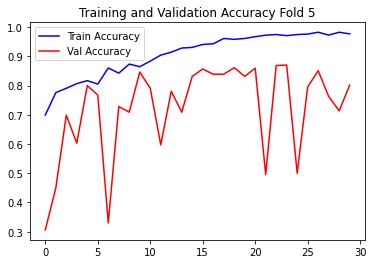

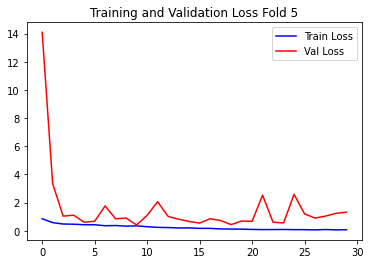

In [20]:
#FOLD 5
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 5')
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 5.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Loss Fold 5')
plt.plot(model_history[4].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 5.jpg")
plt.show()

**LOAD BEST MODEL BY RESULT**

In [21]:
modeltest = load_model('model.alexnet')

**EVALUATING PARAMETER**

In [22]:
print("[INFO] evaluating network...")
predictions = modeltest.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=label_binarizer.classes_))

[INFO] evaluating network...
                precision    recall  f1-score   support

        Blight       0.67      0.91      0.77       224
   Common_Rust       0.99      0.90      0.94       299
Gray_Leaf_Spot       0.49      0.15      0.23       114
       Healthy       0.88      1.00      0.94       201

      accuracy                           0.82       838
     macro avg       0.76      0.74      0.72       838
  weighted avg       0.81      0.82      0.80       838



In [23]:
print("[INFO] Calculating model accuracy")
scores = modeltest.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
27/27 [==============================] - 0s 5ms/step - loss: 0.4237 - accuracy: 0.8234
Test Accuracy: 82.33889937400818


**CONFUSION MATRIX**

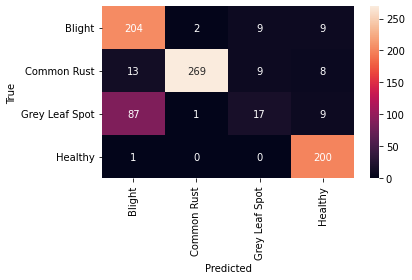

In [24]:
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))
x_axis_labels = ['Blight', 'Common Rust', 'Grey Leaf Spot', 'Healthy']
y_axis_labels = ['Blight', 'Common Rust', 'Grey Leaf Spot', 'Healthy']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()